# Samples for MusicVAE and Miditok

In [1]:
import miditoolkit
from miditoolkit import MidiFile, notes2pianoroll
from miditok import (REMI, CPWord, Event, MIDILike, MIDITokenizer, MuMIDI,
                     OctupleMono)

path_midi = miditoolkit.midi.utils.example_midi_file()
midi = MidiFile(path_midi)

In [2]:
from typing import List
from src.tokenizers import split_to_bars

tokenizer = REMI()
tokens = tokenizer.midi_to_tokens(midi)[0]

print(len(tokens))

2404


<AxesSubplot:>

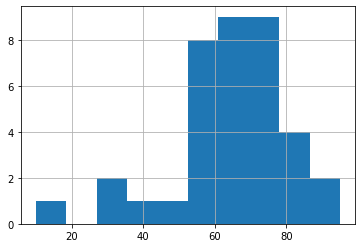

In [3]:
import pandas as pd

tokens_split = split_to_bars(tokens, tokenizer)
pd.Series([len(l) for l in tokens_split]).hist()

In [4]:
split_midi = tokenizer.tokens_to_midi([tokens_split[1]])

In [13]:
from src.utils import miditoolkit_to_notesequence
from note_seq import plot_sequence

plot_sequence(miditoolkit_to_notesequence(midi))
plot_sequence(miditoolkit_to_notesequence(split_midi))

Loading BokehJS ...

Loading BokehJS ...

In [15]:
from src.utils import extract_target_part

midi.instruments

[Instrument(program=0, is_drum=False, name="piano"),
 Instrument(program=0, is_drum=False, name="melody")]

# Training

In [1]:
from src.config import MusicVAEConfig
from argparse import Namespace

args = Namespace(
    target_instrument="melody", learning_rate=1e-4, epochs=10, batchsize=32,
    dataset_dir="/home/atsuya/datasets/meta_midi_dataset/MMD_MIDI/",
    encoding_method="remi")
config = MusicVAEConfig(args)
tokenizer = config.tokenizer_type()


In [2]:
from src.datasets import MidiDataModule, _tokenize_midi_file

data = MidiDataModule(tokenizer, config, 
                      max_n_midi_files=1000,
                      shuffle_data_pathes=True,
                      max_seq_length=1024)


In [3]:
data.prepare_data()
data.setup()

Loading MIDI files: 100%|██████████| 1000/1000 [00:10<00:00, 97.86it/s]


## Data Distribution

count    9506.0
mean     1024.0
std         0.0
min      1024.0
25%      1024.0
50%      1024.0
75%      1024.0
max      1024.0
dtype: float64


<AxesSubplot:>

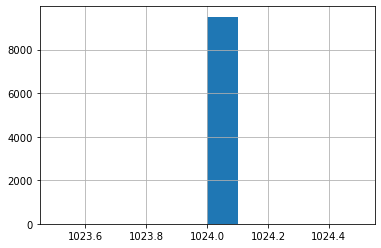

In [4]:
import pandas as pd

len_dist = pd.Series([len(t) for t in data.dataset.all_tokens])
print(len_dist.describe())
len_dist.hist()

In [6]:
from random import choice
from src.utils import miditoolkit_to_notesequence
from note_seq import plot_sequence

for i in range(5):
    plot_sequence(miditoolkit_to_notesequence(
        tokenizer.tokens_to_midi([choice(data.dataset.all_tokens)])))


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [8]:
for idx, d in enumerate(data.train_dataloader()):
    if idx == 1:
        break

{'input_ids': tensor([[  1, 186,  50,  ...,   0,   0,   0],
        [  1,   1,   1,  ...,   0,   0,   0],
        [  1, 194,  34,  ...,   0,   0,   0],
        ...,
        [  1,   1, 202,  ...,   0,   0,   0],
        [  1, 186,  23,  ...,   0,   0,   0],
        [  1, 186,  47,  ...,   0,   0,   0]])}


In [13]:
d["input_ids"].size()

torch.Size([32, 1024])

In [12]:
from src.datasets import _tokenize_midi_file, extract_target_part
import miditoolkit
from miditoolkit import MidiFile, notes2pianoroll
from miditok import (REMI, CPWord, Event, MIDILike, MIDITokenizer, MuMIDI,
                     OctupleMono)

path_midi = miditoolkit.midi.utils.example_midi_file()
midi = MidiFile(path_midi)
midis = extract_target_part(midi, 'melody')
midis

[ticks per beat: 480
 max tick: 72002
 tempo changes: 68
 time sig: 2
 key sig: 0
 markers: 0
 lyrics: False
 instruments: 1,
 ticks per beat: 480
 max tick: 72002
 tempo changes: 68
 time sig: 2
 key sig: 0
 markers: 0
 lyrics: False
 instruments: 1]

## Check Network Graph

In [5]:
from src.models import LtMusicVAE

model = LtMusicVAE(data.tokenizer, config)

In [6]:
import torch

_input = torch.randint(0, len(tokenizer.vocab), (32, 1024))
mu, sigma = model.encoder(_input)

In [7]:
print("mu: ", mu.size())
print("sigma: ", sigma.size())

mu:  torch.Size([32, 512])
sigma:  torch.Size([32, 512])


In [8]:
z = model.reparametrize(mu, sigma)

In [9]:
print("z: ", z.size())

z:  torch.Size([32, 512])


In [10]:
decoded = model.decoder(z)

In [11]:
decoded.size()

torch.Size([32, 1024, 218])

In [12]:
for idx, d in enumerate(data.train_dataloader()):
    if idx == 1:
        break
x, z, mu, sigma = model(d["input_ids"])

In [13]:
print(x.size())
print(d["input_ids"].size())

torch.Size([32, 1024, 218])
torch.Size([32, 1024])


In [35]:
x.transpose(1, 2).size()

torch.Size([32, 218, 1024])

In [36]:

from torch.nn.functional import binary_cross_entropy, nll_loss

nll_loss(x.transpose(1, 2), d["input_ids"], ignore_index=0)

tensor(-0.0046, grad_fn=<NllLoss2DBackward>)

In [45]:
sigma + 1

tensor([[1.0452, 0.9702, 1.0159,  ..., 1.0049, 1.0567, 1.0468],
        [1.0885, 1.0312, 1.0289,  ..., 1.0259, 1.0585, 1.0647],
        [1.0646, 1.0344, 1.0075,  ..., 0.9881, 1.0511, 1.0192],
        ...,
        [1.0887, 1.0322, 1.0287,  ..., 1.0265, 1.0593, 1.0659],
        [1.0579, 1.0288, 1.0160,  ..., 0.9967, 1.0532, 1.0109],
        [1.0657, 0.9650, 0.9859,  ..., 0.9839, 1.0438, 1.0358]],
       grad_fn=<AddBackward0>)

In [46]:
from torch.distributions.kl import kl_divergence
from torch.distributions.normal import Normal

sigma_prior = torch.tensor([1.0])
mu_prior = torch.tensor([0.0])
p = Normal(mu_prior, sigma_prior)
q = Normal(mu, sigma + 1)

In [51]:
sigma

tensor([[ 0.0452, -0.0298,  0.0159,  ...,  0.0049,  0.0567,  0.0468],
        [ 0.0885,  0.0312,  0.0289,  ...,  0.0259,  0.0585,  0.0647],
        [ 0.0646,  0.0344,  0.0075,  ..., -0.0119,  0.0511,  0.0192],
        ...,
        [ 0.0887,  0.0322,  0.0287,  ...,  0.0265,  0.0593,  0.0659],
        [ 0.0579,  0.0288,  0.0160,  ..., -0.0033,  0.0532,  0.0109],
        [ 0.0657, -0.0350, -0.0141,  ..., -0.0161,  0.0438,  0.0358]],
       grad_fn=<LogBackward>)

In [50]:
q = Normal(mu, abs(sigma))

## free notes

In [20]:
import torch.nn as nn

m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()
# input is of size N x C = 3 x 5
input = torch.randn(3, 5, requires_grad=True)
# each element in target has to have 0 <= value < C
target = torch.tensor([1, 0, 4])
output = loss(m(input), target)


In [24]:
input.size()

torch.Size([3, 5])

In [25]:
target.size()

torch.Size([3])

In [23]:
m(input).size()

torch.Size([3, 5])

In [38]:
from torch import Tensor as T

batch_size = 32
hidden_size = 1024
output_size = 512


# conductor_out: [1, output_size]
_cond_input = torch.zeros(
    batch_size, 16, output_size)
_cond_init = (torch.rand(2, batch_size, hidden_size),
              torch.stack([torch.tanh(model.decoder.fc(z)),
                           torch.tanh(model.decoder.fc(z))]))  # 2 layers LSTM
conductor_out, (cond_c, cond_h) = model.decoder.conductor(
    _cond_input, _cond_init)

output: T = torch.tensor([[]])  # [batch, segment_seq]
last_decoder_c: T = torch.rand(2, batch_size, model.decoder.hidden_size)
for segment_idx in range(model.decoder.conductor_max_len):
    results: T = torch.tensor([[]])
    for token_idx in range(model.decoder.decoder_max_len):
        # concat last hidden and concuctor out
        _input = torch.cat([torch.tanh(model.decoder.fc_2(conductor_out[:, segment_idx, :])),
                            torch.tanh(model.decoder.fc_2(last_decoder_c.mean(dim=0)))], dim=1).view(batch_size, 1, model.decoder.output_size)
        decoder_out, (decoder_c, _) = model.decoder.decoder(_input)
        last_decoder_c = decoder_c
        result = model.decoder.sample(decoder_out[:, 0, :])  # [batch]]
        output = torch.cat([output, result], 1)  # [batch, seq_len]


In [51]:
torch.cat([torch.rand(32).view(32, 1) for _ in range(16)], dim=1).size()

torch.Size([32, 16])

In [42]:
output = torch.stack([output, result])  # [batch, seq_len]

RuntimeError: stack expects each tensor to be equal size, but got [1, 0] at entry 0 and [32] at entry 1

In [31]:
torch.tanh(model.decoder.fc_2(last_decoder_c.mean(dim=0))).size()

torch.Size([32, 256])

In [24]:
last_decoder_c.size()

torch.Size([32, 1024])

In [25]:
_cond_input.size()

torch.Size([32, 16, 256])

In [28]:
conductor_out.size()

torch.Size([32, 16, 1024])

In [30]:
cond_h.size()

torch.Size([2, 32, 1024])

In [27]:
segment_idx = 0
_input = torch.zeros(
    batch_size, model.decoder.decoder_max_len, model.decoder.output_size)
_init = (last_decoder_c,
         conductor_out[:, segment_idx, :].view(1, batch_size, model.decoder.hidden_size))


In [22]:
torch.cat([conductor_out[0, :, :], conductor_out[1, :, :]], dim=1).size()

torch.Size([32, 2048])